# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
os_file = 'Reacher_Windows_x86_64/Reacher.exe'
# os_file = 'Reacher_Linux/Reacher.x86_64' # 'Reacher_Linux_NoVis/Reacher.x86_64'
env = UnityEnvironment(file_name=os_file)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
# size of each action
action_size = brain.vector_action_space_size
# size of the state space 
states = env_info.vector_observations
state_size = states.shape[1]

print('Number of agents:', num_agents)
print('Size of each action:', action_size)
print('action description: ',brain.vector_action_descriptions)
print('vector_observations have shape: ',states.shape)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('States is type: ',type(states))

Number of agents: 20
Size of each action: 4
action description:  ['', '', '', '']
vector_observations have shape:  (20, 33)
There are 20 agents. Each observes a state with length: 33
States is type:  <class 'numpy.ndarray'>


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
import time
import numpy as np
# keep track of how long training takes
# widget bar to display progress
#!pip install progressbar
import matplotlib.pyplot as plt
import progressbar as pb
import torch
import torch.optim as optim
from ACnets import Policy, Critic

# Get device available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: ",device)


using device:  cpu


When finished, you can close the environment.

In [26]:
def get_samples(env, policy, critic, noise=1., train_mode=True):
    brain_name = env.brain_names[0]
    env_info = env.reset(train_mode=train_mode)[brain_name]     # reset the environment    
    # get the current state (for each agent)
    states = env_info.vector_observations 
    # initialize containers
    scores = np.zeros(num_agents)                          
    States, Mact, Actions, Rewards, Vs = [], [], [], [], []
    #loop until episode is done
    while True:
        states = torch.tensor(states,dtype=torch.float,device=device)
        mu_actions = policy(states).cpu().detach().numpy()
        actions = mu_actions + noise*np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                                     # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        s_vals = critic(states).cpu().detach().numpy()     # get state value
        #add info to episode lists
        States.append(states.cpu().detach().numpy())
        Mact.append(mu_actions)
        Actions.append(actions)
        Rewards.append(np.array(rewards))
        Vs.append(s_vals)
        #perform step
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    
    States = np.asarray(States)
    Mact = np.asarray(Mact)
    Actions = np.asarray(Actions)
    Rewards = np.asarray(Rewards)
    Vs = np.squeeze(np.asarray(Vs))
    return States, Mact, Actions, Rewards, Vs, scores

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [27]:
def norm_returns(rewards, discount):
    discouted_rewards =  np.asarray([rewards[i]*discount**i for i in range(len(rewards))],dtype=np.float32)
    #convert to future rewards
    future_rewards = np.cumsum(discouted_rewards[::-1],axis=0)[::-1]
    returns = future_rewards.copy()
    #normalize rewards
#     mu = np.mean(future_rewards,axis=1)
#     stdv = np.std(future_rewards,axis=1) + 1.e-10
#     returns = (future_rewards - mu[:,np.newaxis])/stdv[:,np.newaxis]
#     print(returns.shape)
    return returns

def advantage_estimate(rewards, discount, Vs, lmda):
    V_next = np.concatenate((Vs[1:],np.zeros(Vs[0].shape)[np.newaxis]),axis=0)
    TD_error = rewards + discount*V_next - Vs
    truncation_weights = [[(discount*lmda)**i] for i in range(len(rewards))]
    advantage = [np.sum(TD_error[i:]*truncation_weights[::-1][i:][::-1],axis=0) for i in range(len(rewards))]
    advantage = np.asarray(advantage)
    return advantage

In [13]:
# initialize actor and critic 
policy = Policy(state_size, action_size).to(device)
critic = Critic(state_size).to(device)

Actor has input size 33  hidden layer 1 size:  256  hidden layer 2 size:  256  action_size 4
Critic has input size 33  hidden layer 1 size:  256  hidden layer 2 size:  256


In [14]:
States, Mact, Actions, Rewards, Vs, scores = get_samples(env, policy, critic, noise=0.1)
print(np.mean(scores))
print(States.shape, Mact.shape, Actions.shape, Rewards.shape, Vs.shape)

0.5274999882094562
(1001, 20, 33) (1001, 20, 4) (1001, 20, 4) (1001, 20) (1001, 20)


1000.5 0.5
(1001, 20)
4.35889893520734 -1.219710235083998
(1001, 20) (1001, 20)


([array([761., 230.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 167.,  35., 486., 290.,  23.,   0.,   0.,   0.,   0.]),
  array([761., 230.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([761., 230.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([592., 399.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([729., 262.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 120.,  11.,  53., 453., 364.,   0.,   0.,   0.,   0.]),
  array([  0.,  36.,  95.,  39., 206., 238., 326.,  61.,   0.,   0.]),
  array([178., 660., 124.,  39.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 168.,  12.,  35., 371., 327.,  88.,   0.,   0.,   0.]),
  array([761., 230.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 121., 345., 461.,  29.,  45.,   0.,   0.,   0.,   0.]),
  array([  0.,   0., 451., 351.,  24.,   5.,  47.,   3.,  33.,  87.]),
  array([761., 230.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  arra

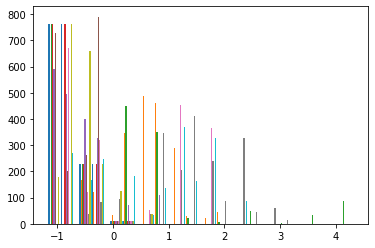

In [17]:
discount, lmda = 1,1
Adv = advantage_estimate(np.ones_like(Rewards), discount, 0.5*np.ones_like(Vs), lmda)
print(Adv.max(),Adv.min())
Ret = norm_returns(Rewards, discount)
print(Ret.max(),Ret.min())
print(Adv.shape,Ret.shape)
plt.hist(Ret)

In [28]:
def PPO(policy, states, mean_actions, actions, advantage, noise, epsilon=0.1, debug=False):

    # convert states to policy
    new_means = policy(states)
    #compute probabilities ratio = new_probs/old_probs
    Delta = torch.norm(actions-mean_actions,p=None,dim=-1)**2 - torch.norm(actions-new_means,p=None,dim=-1)**2
    ratio = torch.exp(Delta/(2*noise**2))
    if debug:
        print(ratio)
        print((new_means-mean_actions).mean(),((new_means-mean_actions)**2).max())

    #compute returns and clipped function
    min_ratio = torch.min(advantage*ratio, advantage*torch.clamp(ratio, 1-epsilon, 1+epsilon))
    
    return -torch.mean(min_ratio)

def Lcritic(critic, states, returns_estimation):
    # convert states to value
    values = critic(states).view(-1)
    return torch.nn.functional.mse_loss(returns_estimation, values)

def get_minibatches(data_size, batch_size, suffle=True):
    indices = np.arange(data_size)
    if suffle:
        np.random.shuffle(indices)
    for mb in range(0,data_size-batch_size + 1, batch_size):
        get_indx = indices[mb:mb+batch_size]
        yield get_indx

In [54]:
#When working in udacity's workspace, avoid sleeping:
#from workspace_utils import keep_awake --> keep_awake(range(episode))

# hyper-parameters
episode = 50

def train(envs, policy, critic, episode, lr_act=2e-4, lr_crit=1e-4, discount=.99, lmda=0.95,
          noise=1., noise_decay=0.98, epsilon=0.2, SGD_epoch=3, batch_size=64):
    
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
    timer = pb.ProgressBar(widgets=widget, maxval=episode).start()
    
    optimizer = optim.Adam(policy.parameters(), lr=lr_act)
    critic_optimizer = optim.Adam(critic.parameters(), lr=lr_crit)

    # keep track of progress
    mean_rewards = []
    ploss = []
    closs = []

    for e in range(episode):

        # collect trajectories
        States, Mact, Actions, Rewards, Vs, scores = get_samples(envs, policy, critic, noise=noise)
        # return estimation 
        returns_estimation = norm_returns(Rewards, discount)
        #get advantage estimation
        advantage = advantage_estimate(Rewards, discount, Vs, lmda)
        #normalize advantage
        advantage = (advantage - np.mean(advantage))/(np.std(advantage)+1.e-10) 

        total_rewards = np.sum(Rewards, axis=0)

        #transform to tensors and flatten: States, Mact, Actions, advantage,returns_estimation
        States = torch.tensor(States, dtype=torch.float, device=device).view(-1,States.shape[-1])
        returns_estimation = torch.tensor(returns_estimation, dtype=torch.float, device=device).view(-1)
        advantage = torch.tensor(advantage, dtype=torch.float, device=device).view(-1)
        Actions = torch.tensor(Actions, dtype=torch.float, device=device).view(-1,Actions.shape[-1])
        Mact = torch.tensor(Mact, dtype=torch.float, device=device).view(-1,Mact.shape[-1])

        # gradient ascent step
        for _ in range(SGD_epoch):
            
            for minibatch in get_minibatches(len(States), batch_size):
                states, m_act, actions, adv = States[minibatch], Mact[minibatch], Actions[minibatch], advantage[minibatch]
                returns = returns_estimation[minibatch]
#                 print(states.shape, m_act.shape, actions.shape, adv.shape, returns.shape)
                #PPO return function
                policy_loss = PPO(policy, states, m_act, actions, adv, noise, epsilon=epsilon)
                # Critic loss
                critic_loss = Lcritic(critic, states, returns)
                #update policy
                optimizer.zero_grad()
                policy_loss.backward()
                optimizer.step()
                #update critic
                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()
                
            policy_loss = PPO(policy, States, Mact, Actions, advantage, noise, epsilon=epsilon, debug=False)
            critic_loss = Lcritic(critic, States, returns_estimation)  
            ploss.append(policy_loss.data)
            closs.append(critic_loss.data)
                
            #print(policy_loss.data)
        # the clipping parameter and noise reduces as time goes on
        epsilon*=.999
        noise *= noise_decay # this reduces exploration in later runs

        # get the average reward of the parallel environments
        mean_rewards.append(np.mean(total_rewards))

        # display some progress every 20 iterations
        if (e+1)%5 ==0 :
            print("Episode: {0:d}, score (averaged over agents): {1:f}".format(e+1,np.mean(total_rewards)))
            print("Policy loss: {} | Critic loss: {}".format(policy_loss.data,critic_loss.data))
            #print(total_rewards)

        # update progress widget bar
        timer.update(e+1)

    timer.finish()
    return mean_rewards, ploss, closs

In [55]:
inputsize, action_size = state_size, action_size
policy = Policy(inputsize, action_size).to(device)
critic = Critic(inputsize).to(device)

Actor has input size 33  hidden layer 1 size:  256  hidden layer 2 size:  256  action_size 4
Critic has input size 33  hidden layer 1 size:  256  hidden layer 2 size:  256


Episode: 5, score (averaged over agents): 0.451000
Policy loss: -0.03683508187532425 | Critic loss: 0.00011589968926273286


Episode: 10, score (averaged over agents): 1.731000
Policy loss: -0.05652188882231712 | Critic loss: 0.0006474917172454298


Episode: 15, score (averaged over agents): 2.367000
Policy loss: -0.0528721809387207 | Critic loss: 0.0013017667224630713


Episode: 20, score (averaged over agents): 3.025000
Policy loss: -0.057698994874954224 | Critic loss: 0.0009837383404374123


Episode: 25, score (averaged over agents): 4.487000
Policy loss: -0.0563729852437973 | Critic loss: 0.0021843810100108385


Episode: 30, score (averaged over agents): 5.849000
Policy loss: -0.05647642910480499 | Critic loss: 0.005142091307789087


Episode: 35, score (averaged over agents): 7.073500
Policy loss: -0.05923021584749222 | Critic loss: 0.0060060471296310425


Episode: 40, score (averaged over agents): 8.036000
Policy loss: -0.056812409311532974 | Critic loss: 0.007165066432207823


Episode: 45, score (averaged over agents): 6.695000
Policy loss: -0.0022453032433986664 | Critic loss: 0.004008280113339424


Episode: 50, score (averaged over agents): 7.832500
Policy loss: -0.04644623398780823 | Critic loss: 0.007927210070192814


Episode: 55, score (averaged over agents): 6.768500
Policy loss: -0.03537113964557648 | Critic loss: 0.006997089367359877


Episode: 60, score (averaged over agents): 7.400000
Policy loss: -0.035274937748909 | Critic loss: 0.004499098751693964


Episode: 65, score (averaged over agents): 7.387000
Policy loss: -0.023843813687562943 | Critic loss: 0.005321772303432226


Episode: 70, score (averaged over agents): 9.231000
Policy loss: -0.038040321320295334 | Critic loss: 0.011791082099080086


Episode: 75, score (averaged over agents): 7.969500
Policy loss: -0.01829332299530506 | Critic loss: 0.009390085935592651


Episode: 80, score (averaged over agents): 7.746000
Policy loss: -0.029703855514526367 | Critic loss: 0.008591428399085999


Episode: 85, score (averaged over agents): 5.980000
Policy loss: -0.017252087593078613 | Critic loss: 0.005523249506950378


Episode: 90, score (averaged over agents): 9.980500
Policy loss: -0.016433745622634888 | Critic loss: 0.010052564553916454


Episode: 95, score (averaged over agents): 14.525000
Policy loss: -0.019521018490195274 | Critic loss: 0.020298251882195473


Episode: 100, score (averaged over agents): 11.524500
Policy loss: -0.022842923179268837 | Critic loss: 0.022785259410738945


Episode: 105, score (averaged over agents): 10.566500
Policy loss: -0.002762902295216918 | Critic loss: 0.013054588809609413


Episode: 110, score (averaged over agents): 8.566000
Policy loss: -0.006244206335395575 | Critic loss: 0.011881659738719463


Episode: 115, score (averaged over agents): 7.177500
Policy loss: 8.617873390903696e-05 | Critic loss: 0.004757335409522057


Episode: 120, score (averaged over agents): 5.704500
Policy loss: 0.016940424218773842 | Critic loss: 0.007939097471535206


Episode: 125, score (averaged over agents): 3.043500
Policy loss: 0.026893138885498047 | Critic loss: 0.0025371077936142683


Episode: 130, score (averaged over agents): 1.623500
Policy loss: 0.028150023892521858 | Critic loss: 0.00044270799844525754


Episode: 135, score (averaged over agents): 3.114500
Policy loss: 0.0430305115878582 | Critic loss: 0.003021574579179287


Episode: 140, score (averaged over agents): 0.086500
Policy loss: 0.024343766272068024 | Critic loss: 4.1543749830452725e-05


Episode: 145, score (averaged over agents): 0.056500
Policy loss: 0.01032380573451519 | Critic loss: 1.2543603588710539e-05


Episode: 150, score (averaged over agents): 0.005000
Policy loss: 0.011135893873870373 | Critic loss: 2.787882294796873e-05
Networks saved


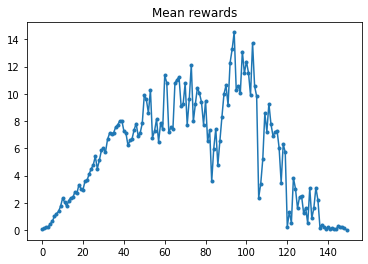

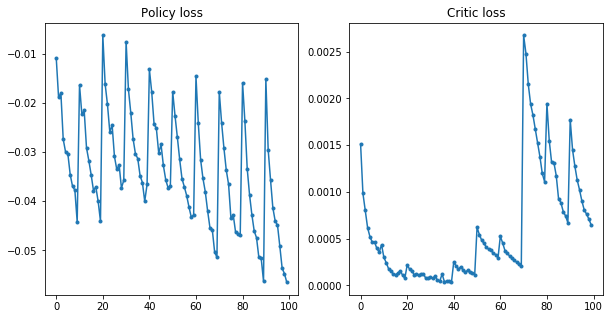

In [56]:
mean_rewards, ploss, closs = train(env, policy, critic, 60, noise=0.1, noise_decay=1., SGD_epoch=10)
# I need to stabilize learning. Possible ways:
#  1. decrease noise_decay (tested 0.98 but maybe a bit smaller)
#  2. decrease epsilon to 0.1
#  3. implement noise learning

# Save actor and critic
# torch.save(policy.state_dict(), 'Reacher.policy')
# torch.save(critic.state_dict(), 'Reacher.critic')
# print('Networks saved')

Text(0.5, 1.0, 'Critic loss')

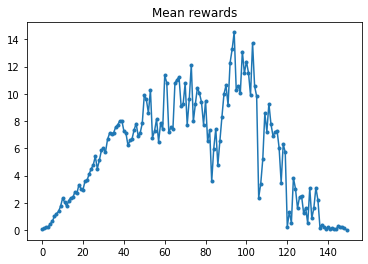

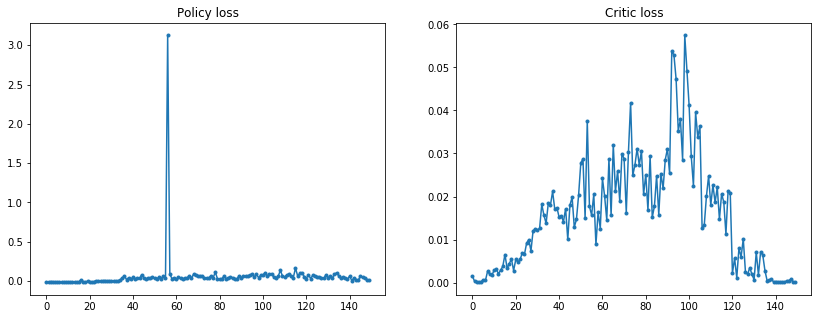

In [76]:
plt.figure()
plt.plot(mean_rewards,'.-')
plt.title("Mean rewards")
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(ploss[::10],'.-')
plt.title("Policy loss")
plt.subplot(122)
plt.plot(closs[::10],'.-')
plt.title("Critic loss")
#[:100]

In [71]:
print([(i, 0.97**i) for i in range(50)])

[(0, 1.0), (1, 0.97), (2, 0.9409), (3, 0.912673), (4, 0.8852928099999999), (5, 0.8587340256999999), (6, 0.8329720049289998), (7, 0.8079828447811298), (8, 0.7837433594376959), (9, 0.7602310586545651), (10, 0.7374241268949281), (11, 0.7153014030880802), (12, 0.6938423609954377), (13, 0.6730270901655746), (14, 0.6528362774606074), (15, 0.6332511891367891), (16, 0.6142536534626855), (17, 0.5958260438588049), (18, 0.5779512625430407), (19, 0.5606127246667495), (20, 0.543794342926747), (21, 0.5274805126389446), (22, 0.5116560972597762), (23, 0.49630641434198286), (24, 0.48141722191172337), (25, 0.4669747052543717), (26, 0.4529654640967405), (27, 0.4393765001738383), (28, 0.42619520516862314), (29, 0.4134093490135644), (30, 0.4010070685431575), (31, 0.38897685648686275), (32, 0.37730755079225686), (33, 0.36598832426848915), (34, 0.35500867454043444), (35, 0.3443584143042214), (36, 0.33402766187509475), (37, 0.3240068320188419), (38, 0.31428662705827665), (39, 0.3048580282465283), (40, 0.29571

In [ ]:
env.close()